# Calculating Deree of Mask Weight Sharing

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.addmul import HandleAddMul

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

network_cache_dir = "networks/cache-networks/"
network_name = "lyr256-split0.8-lr0.01-add-mul.data"

checkpoint = True
test_flag = 1

input_dims = [42]
output_dims = [20]
batchsize = 128
num_epochs = 1

In [2]:
'''Initialise logits & define loss and Optimiser'''
handler = HandleAddMul(input_dims, output_dims, dir=network_cache_dir+network_name, 
                       checkpoint=checkpoint, use_optimiser=False)
handler.network.eval()

add_logits = torch.load('trainedmasks/trained_logits_add_mask_v0.pt')
mul_logits = torch.load('trainedmasks/trained_logits_mul_mask_v0.pt')

binary_add_mask = []
binary_mul_mask = []
with torch.no_grad():
    for add_layer, mul_layer in zip(add_logits, mul_logits):
        binary_add_mask.append((torch.sigmoid(add_layer) > 0.5).float())
        binary_mul_mask.append((torch.sigmoid(mul_layer) > 0.5).float())

... FNN Network training on cuda:0 ...
Accessing : networks/cache-networks/lyr256-split0.8-lr0.01-add-mul.data
networks/cache-networks/lyr256-split0.8-lr0.01-add-mul.data


# Calculate the Number of Shared Weights in each Layer

In [6]:
shared_weights = []
with torch.no_grad():
    for add_layer, mul_layer in zip(binary_add_mask, binary_mul_mask):
        add_layer = torch.flatten(add_layer)
        mul_layer = torch.flatten(mul_layer)
        shared_mask = add_layer*mul_layer
        shared = torch.sum(shared_mask).cpu().numpy()/len(add_layer)
        shared_weights.append(shared)
print(shared_weights)

[0.6201190476190476, 0.8392965, 0.92570525, 0.94004175, 0.929035, 0.9376775, 0.874975]


## Plot results for shared weights by layer

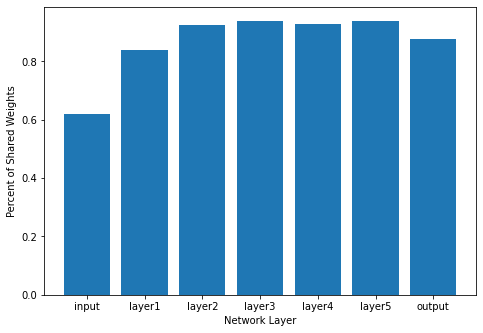

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
layer_names = ['input', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'output']
ax.bar(layer_names, shared_weights, width = 0.8)
ax.set_xlabel('Network Layer')
ax.set_ylabel('Percent of Shared Weights')

plt.show()

# Plot result for total percent of shared weights

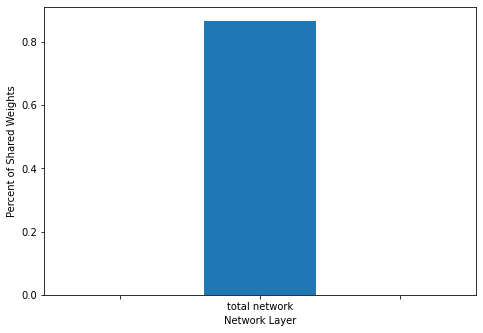

In [18]:
import matplotlib.pyplot as plt
res = np.mean(shared_weights)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
layer_names = [' ','total network', '']
ax.bar(layer_names, [0,res, 0], width = 0.8)
ax.set_xlabel('Network Layer')
ax.set_ylabel('Percent of Shared Weights')

plt.show()